<a href="https://colab.research.google.com/github/marcvonrohr/machine_learning/blob/main/lab_7/unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="center" style="max-width: 900px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_7/banner.png?raw=1">

<img align="right" style="max-width: 200px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_7/hsg_logo.png?raw=1">

##  Lab 07 - Unsupervised Learning

Machine Learning, University of St.Gallen (HSG), Spring Term 2025

The lab environment of the **Machine Learning** course is powered by Jupyter Notebooks (https://jupyter.org), which allows one to perform a great deal of data analysis and statistical validation. In this lab, we will build our own GPT model, multihead self-attention method will be introduced.

In this lab, we will learn two important **unsupervised** machine learning techniques, **k-Means** and **EM Clustering**. We will use these techniques to classify un-labelled data (i.e., data without defined categories or groups). In general, clustering-based techniques are widely used in **unsupervised machine learning**.

### Lab Objectives:

After today's lab, you should be able to:

> 1. Understand how a **k-Means Clustering** algorithm can be trained and evaluated.
> 2. Understand how a **Expectation-Maximization (EM) Clustering** algorithm can be trained and evaluated.
> 3. Know how to select an **optimal number of clusters**.
> 4. Know how to Python's **sklearn library** to perform unsupervised clustering.
> 5. Understand how to **evaluate** and **interpret** the obtained clustering results.

### Setup of the Lab Environment

Similar to the previous labs, we need to import a couple of Python libraries:

In [1]:
# import the pandas data science library
import pandas as pd
import numpy as np

# import the scipy spatial distance capability
from scipy.spatial.distance import cdist

# import sklearn data and data pre-processing libraries
from sklearn import datasets

# import sklearn data sample generator libraries
from sklearn.datasets import make_blobs

# import sklearn k-means and gaussian-mixture classifier library
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# import matplotlib data visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# import matplotlibs 3D plotting capabilities
from mpl_toolkits.mplot3d import Axes3D

Enable inline Jupyter notebook plotting:

In [2]:
%matplotlib inline

Ignore potential library warnings:

In [3]:
import warnings
warnings.filterwarnings('ignore')

Set random seed of all our experiments:

In [4]:
random_seed = 42

## 1. Dataset

We use **Iris Dataset** dataset as our dataset in this lab.

<img align="center" style="max-width: 700px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_7/iris_dataset.png?raw=1">

(Source: http://www.lac.inpe.br/~rafael.santos/Docs/R/CAP394/WholeStory-Iris.html)

In total, the dataset consists of **150 samples** (50 samples taken per class) as well as their corresponding **4 different measurements** taken for each sample. Please, find below the list of the individual measurements:

>- `Sepal length (cm)`
>- `Sepal width (cm)`
>- `Petal length (cm)`
>- `Petal width (cm)`

We can briefly envision how the feature information of the dataset is collected and presented in the data:

<img align="center" style="max-width: 900px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_7/featurecollection.png?raw=1">

Further details on the dataset can be obtained from our SVM lab.

Let's load the dataset and conduct a preliminary data assessment:

In [5]:
iris = datasets.load_iris()

## 2. The k-Means Clustering Algorithm

As explained in the lecture, the **k-Means Clustering** algorithm is one of the most popular "first choice" unsupervised clustering algorithms to find groups (clusters) in a given multidimensional dataset $X$.

<img align="center" style="max-width: 400px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_7/kmeans.png?raw=1">

Thereby, the basic form of k-Means Clustering makes the following **two assumptions**:

- Each observation is closer to its own cluster center than to the center of the other clusters.
- A cluster center is the arithmetic mean of all the points that belong to the cluster.

Let's briefly revisit the distinct step of the algorithm before applying it to the iris dataset. Therefore, let's assume:

- We have dataset $X$ consisting records $x_1, x_2, x_3, ..., x_n$;
- That samples are clustered around $k$ centers (the "$k$ means") denoted by $\mu_1, \mu_{2}, ..., \mu_{k}$; and,
- Each sample $x_{i}$ belongs to its closest mean $\mu_{i}$.

We can then iteratively perform the following steps that comprise the **k-Means Clustering** algorithm:

>- **Step 1** - Pick $k$ random points $\mu_{i}$ as cluster centres called 'means'.
>- **Step 2** - Assign each $x_i$ to its to nearest cluster mean by calculating its distance to each mean.
>- **Step 3** - Determine the new cluster centres by calculating the average of the assigned points in each cluster.
>- **Step 4** - Repeat Step 2 and 3 until none of the cluster assignments change.

Note, that a single execution of all the four steps outlined above is usually referred to as 'iteration'.

### 2.1. k-Means Clustering in a 2-Dimensional Feature Space

Now, let's see how we can apply it to the iris dataset. We will start with an introductory example of detecting the classes of the iris dataset based on two of its features namely the (1) `Petal length (cm)` and (2) `Petal width (cm)`. Let's first gain an intuition of those two features as well as their distribution by visualizing them accordingly:

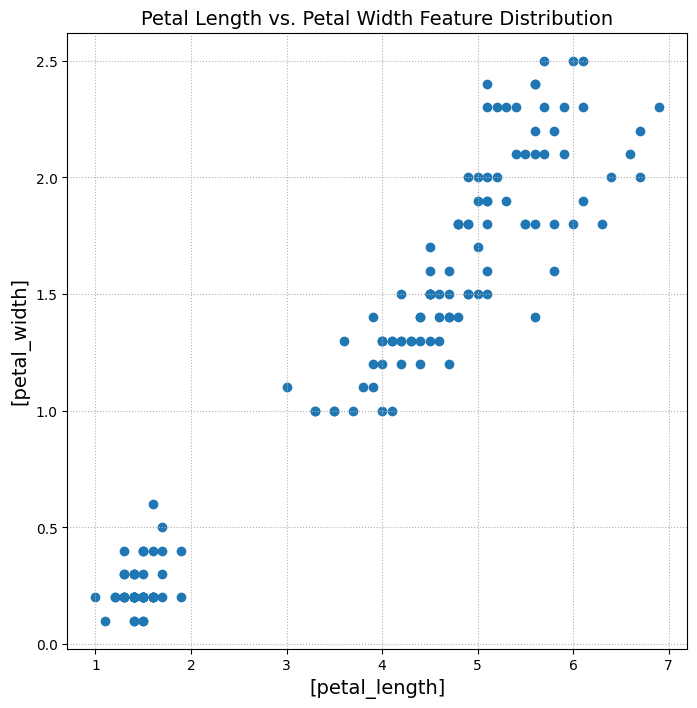

In [6]:
# init the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot petal length (3rd feature in the dataset) vs. petal width (4th feature in the dataset)
ax.scatter(iris.data[:,2], iris.data[:,3])

# add axis legends
ax.set_xlabel("[petal_length]", fontsize=14)
ax.set_ylabel("[petal_width]", fontsize=14)

# add plot title
plt.title('Petal Length vs. Petal Width Feature Distribution', fontsize=14);

Let's now define the parameters of the k-Means Clustering. We will start by specifying the **number of clusters** $k$ we aim to detect in the iris dataset. We hypothesize that our observations are drawn from an unknown distributions of three iris flower species (each distribution corresponding to a different mean $\mu_1$, $\mu_2$, and, $\mu_3$). Therefore, we set the number of clusters to be detected to $k=3$:

In [7]:
no_clusters = 3

Next, we need to define a corresponding number of **initial 'means' $\mu_{i}$** (the initial random cluster centers) that will be used as 'starting points' in the first iteration of the clustering process. In our case we will specify $k=3$ cluster means each of dimension 2, since we aim to retrieve 3 clusters based on the 2 features `Petal length (cm)` and `Petal width (cm)`:

In [8]:
init_means = np.array([[1, 3], [2, 6], [1, 7]])

Finally, we will define a **maximum number of iterations** that we want to run the k-Means Clustering algorithm. Please, note that the clustering terminates once there will be no further changes in the cluster assignments. However, it's good practice to define an upper bound of the iterations applied in the clustering (especially when analyzing datasets that exhibt a high-dimensional feature space):

In [9]:
max_iterations = 10

Now, we are ready to initialize an instance of the **k-Means Clustering** algorithm using Python's `sklearn` library of data science algorithms. Please note again, that for each classifier, available in the `sklearn` library, a designated and detailed documentation is provided. It often also includes a couple of practical examples and use cases. The documentation of the **k-Means Clustering** algorithm can be obtained from the following url:

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Let's use `Scikit-Learn` and instantiate the **k-Means Clustering** algorithm:

In [10]:
kmeans = KMeans(n_clusters=no_clusters, init=init_means, max_iter=max_iterations)

Let's run the k-Means Clustering to learn a model of the `Petal length (cm)` and  `Petal width (cm)` features. Pls. note that we are using columns 2 and 3 to extract the values of the two features from the iris dataset:

In [11]:
kmeans.fit(iris.data[:,2:4]) # note that we are using column 2 (petal length) and 3 (petal width)

KMeans(init=array([[1, 3],
       [2, 6],
       [1, 7]]), max_iter=10,
       n_clusters=3)

Now that we have conducted the clustering, let's inspect the distinct cluster labels that have been assigned to the individual records of the iris dataset. This can be achieved by calling the `labels_` attribute of the fitted model:

In [12]:
labels = kmeans.labels_ # obtain the assigned cluster labels
print(labels)           # print the cluster labels

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 2 1 1 1 1
 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1
 1 1]


Furthermore, we want to inspect the coordinates of the cluster means (sometimes also referred to as "centroids") assigned by the algorithm. This can be achieved by calling the `cluster_centers_`attribute of the fitted model:

In [13]:
means = kmeans.cluster_centers_ # obtain the assigned cluster means
print(means)                    # print the cluster center coordinates

[[1.462      0.246     ]
 [5.63777778 2.06      ]
 [4.30727273 1.36181818]]


Let's now plot the iris dataset records using the two features `Petal length (cm)` and `Petal width (cm)` as well as the labels and cluster means determined by the **k-Means Clustering** algorithm:

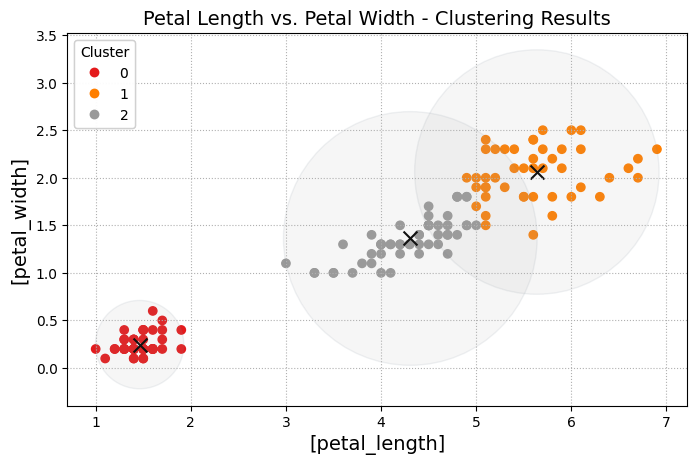

In [14]:
# init the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot petal length vs. petal width and corresponding classes
scatter = ax.scatter(iris.data[:,2], iris.data[:,3], c=labels.astype(np.float64), cmap=plt.cm.Set1)

# prepare data legend
legend = ax.legend(*scatter.legend_elements(), loc='upper left', title='Cluster')

# add legend to plot
ax.add_artist(legend)

# plot cluster means
ax.scatter(means[:,0], means[:,1], marker='x', c='black', s=100)

# iterate over distinct cluster means
for i, mean in enumerate(means):

    # determine max cluster point distance
    cluster_radi = cdist(iris.data[:, 2:4][labels==i], [mean]).max()

    # plot cluster size
    ax.add_patch(plt.Circle(mean, cluster_radi, fc='darkgrey', edgecolor='slategrey', lw=1, alpha=0.1, zorder=1))

# don't scale
ax.set_aspect('equal')

# add axis legends
ax.set_xlabel("[petal_length]", fontsize=14)
ax.set_ylabel("[petal_width]", fontsize=14)

# add plot title
plt.title('Petal Length vs. Petal Width - Clustering Results', fontsize=14);

To build an even better intuition about the k-Means clustering let's have look at the animation of the distinct clustering iterations shown below:

In [18]:
from IPython.display import Video
Video("https://github.com/HSG-AIML-Teaching/ML2025-Lab/raw/refs/heads/main/lab_7/kmeansvideo.mp4", width=700)

It can be observed that, upon convergence, the **k-Means Clustering algorithm** nicely found three clusters in the dateset. Let's inspect to which extend this corresponds to the true 'species' class labels 'verginica', 'setosa', and 'versicolor' of the iris dataset to obtain an idea of the quality of the clusterin result:

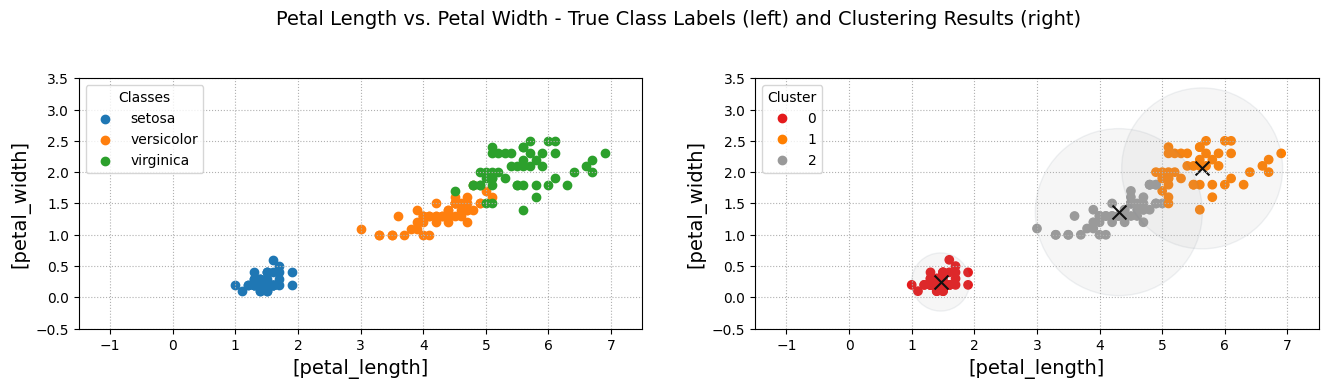

In [19]:
# init the plot
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 4))

#### plot true iris class labels

# add grid
ax[0].grid(linestyle='dotted')

# iterate over distinct species
for species in np.unique(iris.target):

    # obtain iris petal length and petal width
    iris_features = iris.data[iris.target == species,:]

    # obtain iris species name
    iris_target_name = iris.target_names[species]

    # plot petal length vs. petal width as well as the true labels
    ax[0].scatter(iris_features[:,2], iris_features[:,3], c='C{}'.format(str(species)), label=iris_target_name)

# prepare data legend
ax[0].legend(loc='upper left', title='Classes')

# set axis range
ax[0].set_xlim([-1.5, 7.5])
ax[0].set_ylim([-0.5, 3.5])

# add axis legends
ax[0].set_xlabel("[petal_length]", fontsize=14)
ax[0].set_ylabel("[petal_width]", fontsize=14)

#### plot clustering results

# add grid
ax[1].grid(linestyle='dotted')

# plot petal length vs. petal width and corresponding classes
scatter = ax[1].scatter(iris.data[:,2], iris.data[:,3], c=labels.astype(np.float64), cmap=plt.cm.Set1)

# prepare data legend
ax[1].legend(*scatter.legend_elements(), loc='upper left', title='Cluster')

# plot cluster means
ax[1].scatter(means[:,0], means[:,1], marker='x', c='black', s=100)

# iterate over distinct cluster means
for i, mean in enumerate(means):

    # determine max cluster point distance
    cluster_radi = cdist(iris.data[:, 2:4][labels==i], [mean]).max()

    # plot cluster size
    ax[1].add_patch(plt.Circle(mean, cluster_radi, fc='darkgrey', edgecolor='slategrey', lw=1, alpha=0.1, zorder=1))

# don't scale
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

# set axis range
ax[1].set_xlim([-1.5, 7.5])
ax[1].set_ylim([-0.5, 3.5])

# add axis legends
ax[1].set_xlabel("[petal_length]", fontsize=14)
ax[1].set_ylabel("[petal_width]", fontsize=14)

# add plot title
plt.suptitle('Petal Length vs. Petal Width - True Class Labels (left) and Clustering Results (right)', fontsize=14);

Ok, it seems that our clustering did a quite good job.

### 2.2  Drawbacks of the k-Means Clustering Algorithm

Even though the **k-Means Clustering** algorithm is one of the most popular clustering algorithms used in machine learning. There are three major drawbacks associated with it, which are explained hereafter:

1. The k-Means Clustering is guaranteed to improve the result in each iteration but there are **no guarantees** that it will find the **global best of clusters**.

> **Practical solution:** Run the algorithm with multiple random initializations. This also done per default when using the `scikit` learn of machine learning algorithms.

2. The k-Means Clustering **cannot learn** the **optimal number of clusters** from the provided data. E.g., if we ask the algorithm for 20 clusters it will find 20 clusters, which may or may not be meaningful.

> **Practical solution:** Use the "Elbow" technique as explained in the next section of the notebook. Another option might be the usage of a more complex clustering algorithm like Gaussian Mixture Models, or one that can choose a suitable number of clusters, e.g., the DBSCAN clustering algorithm.

3. The k-Means Clustering **doesn't work well** in instances of a **non-linear seperable** dataset. This is caused by its assumption that points will be closer to their own cluster center than to others.

> **Practical solution:** Transform (if possible) the dataset into a higher dimension where a linear separation becomes possible, e.g., by using a spectral clustering algorithm.

4. The k-Means Clustering **doesn't work well** in **skewed distribution**. This is caused by that K-Means places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster.

> **Practical solution:** We can try EM, because it can handle skewed distributions well.

### 2.3  Optimal Cluster Number Selection

Challenge: What is the optimal number of clusters $k$ for a given dataset? Selection of the right $k$ may result in the following issues:

- if $k$ too small (under-segmentation), then the clusters are too diverse; and;
- if $k$ too high (over-segmentation), then the clusters are too fine-grain.

Examples:

<img align="center" style="max-width: 800px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_7/kselection.png?raw=1">

Solution: We can then use the sum of "squared errors" $E(\mu_{1}, \mu_{2}, ..., \mu_{k})$ metric to find an optimal number of clusters $k$! This can be achieved by the execution of the so-called **'Elbow'** technique defined by the following algorithm:

>- **Step 1** - Compute the k-Means clustering algorithm for different number of clusters $k$.
>- **Step 2** - For each $k$ calculate the sum of the within-cluster sum of squared distances $E(\mu_{1}, \mu_{2}, ..., \mu_{k})$.
>- **Step 3** - For each $k$ plot the $k$ value vs. its corresponding sum of within-cluster sum of squared distances $E$.
>- **Step 4** - Inspect the plot and determine the location of a bend (appropriate number of clusters).

Let's utilize the **'Elbow'** technique by first defining a max. number of iterations that we aim to apply at each k-Means clustering run:

In [20]:
max_iterations = 100

Now we can implement the and run the 'elbow' technique:

In [21]:
# init the list of squared distances
sum_of_squared_distances = []

# define the range of k-values to investigate
K = range(1,30)

# iterate over all k-values
for k in K:

    # init the k-Means clustering algorithm of the current k-value
    kmeans = KMeans(n_clusters=k, init='random', max_iter=max_iterations)

    # run the k-Means clustering of sepal-length and sepal-width features
    kmeans = kmeans.fit(iris.data[:,2:4])

    # collect the sum of within squared distances of the current k-value
    sum_of_squared_distances.append(kmeans.inertia_)

Upon completion of the loop above let's inspect the distinct within-cluster sum of squared distances $E$:

In [22]:
# print the collected sum of squared distances of each k
sum_of_squared_distances

[550.8953333333333,
 86.39021984551391,
 31.371358974358966,
 19.46598901098901,
 14.011017376142384,
 11.057257664362925,
 9.19386673204751,
 8.262824823868941,
 7.225802336552337,
 6.427706539507301,
 5.265108669108669,
 4.769391090250673,
 5.10690559732665,
 3.9159291721350553,
 3.821428663570692,
 3.83311070508439,
 3.421022949272946,
 3.3420386002886007,
 2.885409897292251,
 2.821674242424242,
 2.4623225957049484,
 2.4153910533910534,
 2.338016955266955,
 2.2413630952380945,
 2.1311219715956553,
 1.8907788600288609,
 1.881873015873017,
 1.8240119047619048,
 1.7584107142857155]

Furthermore, let's plot the cluster number $k$ vs. the within-cluster sum of squared distances $E$:

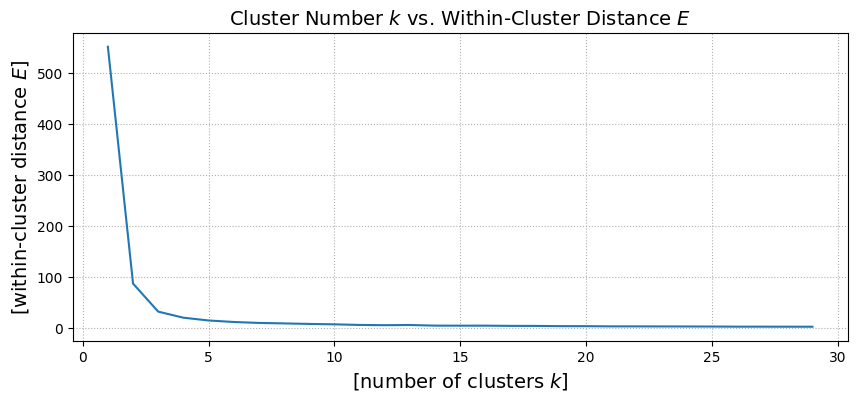

In [23]:
# init the plot
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot petal length (3rd feature in the dataset) vs. petal width (4th feature in the dataset)
ax.plot(K, sum_of_squared_distances)

# add axis legends
ax.set_xlabel("[number of clusters $k$]", fontsize=14)
ax.set_ylabel("[within-cluster distance $E$]", fontsize=14)

# add plot title
plt.title('Cluster Number $k$ vs. Within-Cluster Distance $E$', fontsize=14);

## 3. Expectation Maximization (EM) Algorithm

"One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster" (Jake VanderPlas, The Python Data Science Handbook). To investigate this limitation of the **k-Means Clustering** algorithm let's have a closer look at an exemplary very skewed data distribution.

### 3.1. The case when K-Means fails

Let's create a very skewed distribution that exhibits a eliptical characteristic:

In [24]:
# generate a sample data distribution
data, labels = make_blobs(n_samples = 1000, centers = 3, cluster_std = .7, random_state = 0)

# init the random state and skew the data
random_state = np.random.RandomState(8)
data_skewed = np.dot(data, random_state.randn(2, 2))

Once created, let's visualize the skewed distribution accordingly:

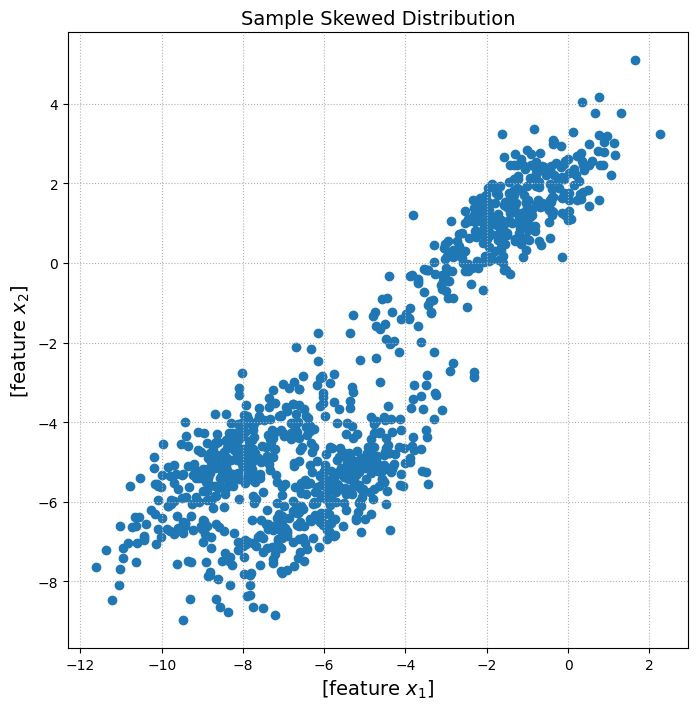

In [25]:
# init the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the two dimensions of the skewed distribution
scatter = ax.scatter(data_skewed[:,0], data_skewed[:,1])

# add axis legends
ax.set_xlabel("[feature $x_1$]", fontsize=14)
ax.set_ylabel("[feature $x_2$]", fontsize=14)

# add plot title
plt.title('Sample Skewed Distribution', fontsize=14);

Ok, the distribution looks indeed very skewed. It furthermore seem to consist of three commingled eliptical clusters. Let's see if we can identify those clusters using the k-Means Clustering algorithm that we discussed before:

In [26]:
# init the k-Means Clustering algorithm
kmeans = KMeans(n_clusters=3, random_state=42, max_iter=100)

# fit the clustering to the the data
kmeans.fit(data_skewed)

# obtain the cluster labels
kmeans_labels_skewed = kmeans.labels_

# obtain the cluster means
kmeans_means_skewed = kmeans.cluster_centers_

Let's now visualize the results of the clustering as well as the obtained clusters:

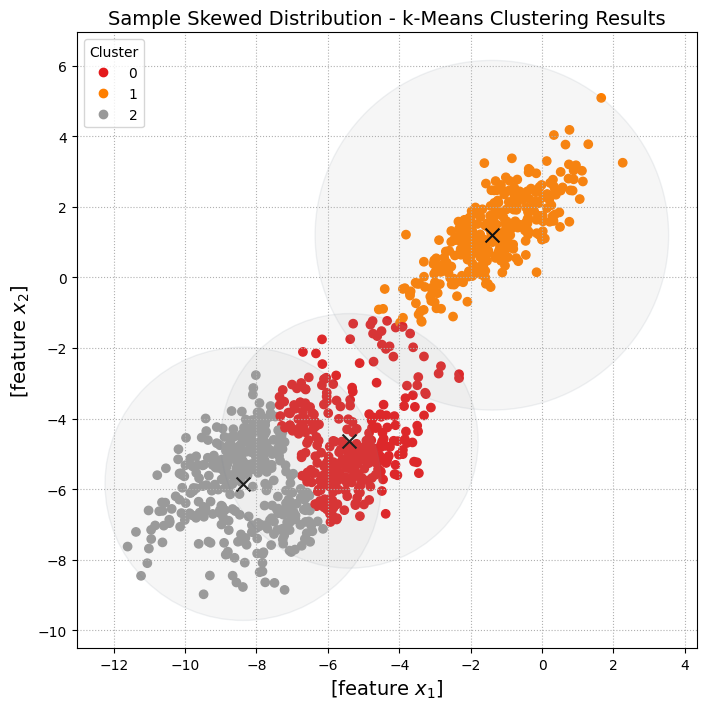

In [27]:
# init the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot petal length vs. petal width and corresponding classes
scatter = ax.scatter(data_skewed[:,0], data_skewed[:,1], c=kmeans_labels_skewed.astype(np.float64), cmap=plt.cm.Set1)

# prepare data legend
ax.legend(*scatter.legend_elements(), loc='upper left', title='Cluster')

# plot cluster means
ax.scatter(kmeans_means_skewed[:,0], kmeans_means_skewed[:,1], marker='x', c='black', s=100)

# iterate over distinct cluster means
for i, mean_skewed in enumerate(kmeans_means_skewed):

    # determine max cluster point distance
    cluster_radi = cdist(data_skewed[:, 0:2][kmeans_labels_skewed==i], [mean_skewed]).max()

    # plot cluster size
    ax.add_patch(plt.Circle(mean_skewed, cluster_radi, fc='darkgrey', edgecolor='slategrey', lw=1, alpha=0.1, zorder=1))

# add axis legends
ax.set_xlabel("[feature $x_1$]", fontsize=14)
ax.set_ylabel("[feature $x_2$]", fontsize=14)

# add plot title
plt.title('Sample Skewed Distribution - k-Means Clustering Results', fontsize=14);

Based on the example above we observe one of the main disadvantages of the **k-Means Clustering** algorithm. The k-Means Clustering has no way to account for oblong or elliptical clusters. Therefore, it fails to recognize the distinct clusters in very skewed distributions.

Unlike the k-Means Clustering algorithm, the **Expectation Maximization (EM)** algorithm (introduced in the following section of the notebook) is not limited to spherical shapes. Using the EM algorithm we can constrain the algorithm to provide different covariance matrices (spherical, diagonal and generic). These different covariance matrices in return allow to control the shape of our clusters and hence we can detect sub-populations in our data with different characteristics.

### 3.2. The Expectation Maximization (EM) Algorithm of Gaussian Mixtures

In **Expectation-Maximization (EM)** clustering, specifically in Gaussian Mixture Models (GMM), each cluster is modeled with a Gaussian (normal) distribution. The algorithm estimates the parameters of the Gaussian distributions (mean and covariance matrix) for each cluster.

<img align="center" style="max-width: 800px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_7/skewnorm.png?raw=1">

(Source: https://gregorygundersen.com/blog/2020/12/29/multivariate-skew-normal/)

The **EM** algorithm is similar to the k-Means Clustering technique. However, instead of assigning examples to clusters to maximize the differences in means, the EM Clustering algorithm computes probabilities of cluster memberships based on one or more probability distributions.

The goal of the clustering algorithm then is to maximize the overall probability or likelihood of the data, given the (final) clusters. Thereby, the objective of EM clustering is to estimate the means and standard deviations for each cluster so as to maximize the likelihood of the observed data (distribution). To achieve this objective the algorithm iteratively computes an **(1) Expectation-Step** and **(2) Maximization-Step** as described in the following:

#### Step-1: The Expectation-Step

In the **"Expectation Step"** we determine the expected values $E(z_{ij} | \mu_{j}^{t}, \sigma_{j}^{t})$ that denotes the probability of a given observation $x_i \in \mathcal{R}^d$ that it was drawn from the $j^{th}$ distribution (or cluster):

$$E(z_{ij}) = \frac{P(x_i|\mu_{j}^{t}, \sigma_{j}^{t})}{\sum_{k'=1}^k P(x_i|\mu_{k'}^{t},\sigma_{k'}^{t})},$$

where:

- $x_i \in X$ denotes a particular data observation;
- $t$ denotes the current iteration of the EM Clustering algorithm;
- $\mu_j$ and $\sigma_j$ denotes the mean and (co-) variance of the $j^{th}$ distribution (or cluster).

During the lecture you learned that the probability distribution of each cluster might be approximated by a Gaussian (Normal) probability distribution $\mathcal{N}(\mu, \sigma)$. Hence the approach is usually referred to as the **EM-Algorithm of Gaussian Mixtures**. In general, the probability density of a Gaussian "Normal" distribution, as defined by the formula below. It is parametrized its mean $\mu$ and corresponding standard deviation $\sigma$:

$$ P(x|\mu,\sigma)  \approx \mathcal{N}(x|\mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{1}{2\sigma^{2}}(x - \mu)^2}$$

Now, we can rewrite the formula of the Expectation Step as:

$$E(z_{ij}) = \frac{P(x_i|\mu_j^{t}, \sigma_j^{t})}{\sum_{k'=1}^k P(x_i|\mu_{k'}^{t},\sigma_{k'}^{t})} = \frac{\mathcal{N}(x_i|\mu_j^{t}, \sigma_j^{t})}{\sum_{k'=1}^k \mathcal{N}(x_i|\mu_{k'}^{t},\sigma_{k'}^{t})} = \frac{ \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{1}{2\sigma_{j}^{t 2}}(x_i - \mu_{j}^{t})^2} }{ \sum_{k'=1}^{k} \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{1}{2\sigma_{k'}^{t 2}}(x_i - \mu_{k'}^{t})^2} }$$

The distinct $E(z_{ij})$ values $z_{1j}$, $z_{2j}$, ..., $z_{nj}$ represent the probability distribution of the $j^{th}$ cluster that the data point is drawn from. Understanding the range of values the $z$ values can take is important. Each observation $x_i$ has k associated $E(z_{ij})$ values. In the **k-Means Clustering** algorithm each $z_{ij}$ can only take the value 0 or 1. This is why the k-Means Clustering algorithm is referred to as **"hard"** clustering.

In contrast, the **"EM-Clustering"** algorithm is referred to as **"soft"** or **"fuzzy"** clustering. In EM-Clustering the distinct observations $x_i$ are considered to be drawn probabilistically from the distinct cluster distributions $j$. The corresponding $z_{ij}$ values can therefore be $z_{i1}$=0.85, $z_{i2}$=0.10 and $z_{i3}$=0.05, which represents a strong probability that the $x_{i}$ value originates from distribution (or cluster) 1 and a exhibit a smaller probability that it originates from distribution (or cluster) 2 or 3.

#### Step-2: The Maximization-Step

In the **"Maximization-Step"** we calculate update the parameters of each Gaussian "Normal" cluster distribution. Therefore, we derive for each $j^{th}$ distribution (or cluster) a new $\mu_{j}$ and $\sigma_{j}$ parameter value as given by:

$$ \mu_{k}^{t+1} = \frac {\sum_{k'=1}^{k}E(z_{ij})x_i} {\sum_{k'=1}^{k}E(z_{ij})}; \sigma_{j}^{t+1} = \frac {\sum_{k'=1}^{k}E(z_{ij}) (x_i - \mu_{k}^{t})^{2}} {\sum_{k'=1}^{k}E(z_{ij})}$$

### 3.3. Expectation Maximization (EM) in a 2-Dimensional Feature Space

Similarly, to k-Means Clustering let's now define the parameters of the **EM-Clustering** algorithm. We will start by specifying the **number of clusters** $k$ we aim to detect in the iris dataset. We again hypothesize that our observations are drawn from an unknown distributions of three iris flower species (each distribution corresponding to a different mean $\mu_1$, $\mu_2$, and, $\mu_3$ and corresponding standard deviation $\sigma_1$, $\sigma_2$, and, $\sigma_3$). Therefore, we set the number of clusters to be detected to $k=3$:

In [28]:
no_clusters = 3

Next, we need to define a corresponding number of **initial 'means' $\mu_{i}$** (the initial random cluster centers) that will be used as 'starting points' in the first iteration of the clustering process. In our case we will specify $k=3$ cluster means each of dimension 2, since we aim to retrieve 3 clusters based on the 2 features $x_1$ and $x_2$:

In [29]:
init_means = np.array([[1.0, 3.0], [2.0, 6.0], [1.0, 7.0]])

Finally, we will define a **maximum number of iterations** that we want to run the **EM-Clustering** algorithm. Please, note that the clustering terminates once there will be no further changes in the cluster assignments. However, it's good practice to define an upper bound of the iterations applied in the clustering (especially when analyzing datasets that exhibt a high-dimensional feature space):

In [30]:
max_iterations = 50

Now, we are ready to initialize an instance of the **EM-Clustering** algorithm using Python's `sklearn` library of data science algorithms. Please note again, that for each classifier, available in the `sklearn` library, a designated and detailed documentation is provided. It often also includes a couple of practical examples and use cases. The documentation of the **EM-Clustering** algorithm can be obtained from the following url:

https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

In [31]:
em = GaussianMixture(n_components=no_clusters, means_init=init_means, max_iter=max_iterations)

Let's run the **EM-Clustering** to learn a model of the $x_1$ and $x_2$ features. Similar to the k-Means Clustering we will again make use of the `fit()` method provided by `sklearn` for each of its classifiers:

In [32]:
em.fit(data_skewed)

GaussianMixture(max_iter=50,
                means_init=array([[1., 3.],
       [2., 6.],
       [1., 7.]]),
                n_components=3)

Now that we have conducted the clustering, let's inspect the distinct cluster labels that have been assigned to the individual records of our artificial dataset. This can be achieved by calling the `predict()` function of the fitted model:

In [33]:
em_labels_skewed = em.predict(data_skewed)

Furthermore, we want to inspect the coordinates of the cluster means (sometimes also referred to as "centroids") assigned by the algorithm. This can be achieved by calling the `means_`attribute of the fitted model:

In [34]:
em_means_skewed = em.means_
em_means_skewed

array([[-5.90010638, -5.78080844],
       [-8.24704079, -4.95007397],
       [-1.54221209,  1.06112137]])

Let's now visually inspect the clustering results of the two features $x_1$ and $x_2$ in terms of the cluster assignments of each observation and cluster means learned by the **EM-Clustering** algorithm:

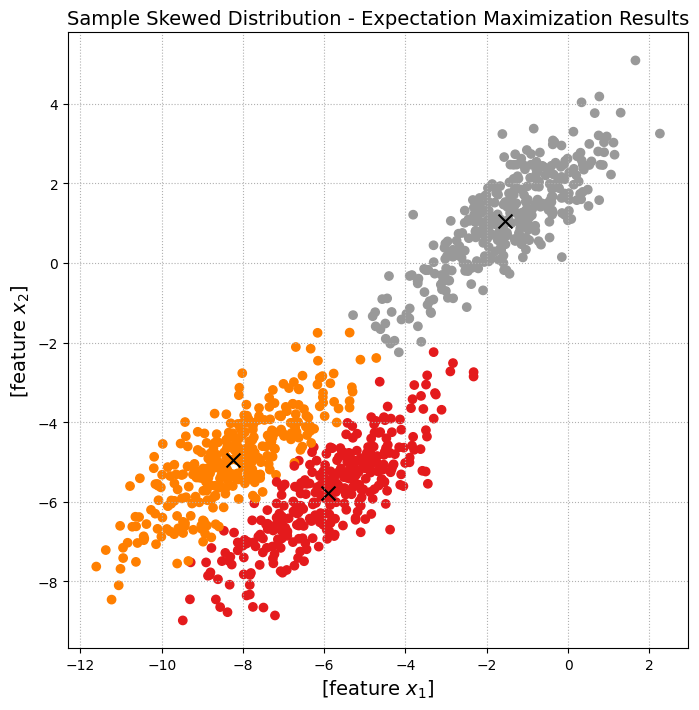

In [35]:
# init the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot x_1 vs. x_2 and corresponding cluster labels
scatter = ax.scatter(data_skewed[:,0], data_skewed[:,1], c=em_labels_skewed.astype(np.float64), cmap=plt.cm.Set1)

# plot cluster means
ax.scatter(em_means_skewed[:,0], em_means_skewed[:,1], marker='x', c='black', s=100)

# add axis legends
ax.set_xlabel("[feature $x_1$]", fontsize=14)
ax.set_ylabel("[feature $x_2$]", fontsize=14)

# add plot title
plt.title('Sample Skewed Distribution - Expectation Maximization Results', fontsize=14);

Ok, we can observe that the **EM Clustering** technique nicely clusters the distinct distributions of the skewed distributions. We notice that the results are quite different from those computed by the k-Means clustering. As initially stated, the EM Clustering determines the **probability of cluster memberships** for each observation based on the initially specified $k$ probability distributions. Let's obtain the probability of each observation using the `predict_proba()` function:

In [36]:
em_probabilities_skewed = em.predict_proba(data_skewed)
em_probabilities_skewed

array([[9.96944810e-01, 3.05421289e-03, 9.76802325e-07],
       [1.03914237e-05, 9.99973458e-01, 1.61503723e-05],
       [9.99430075e-01, 5.69919646e-04, 5.71520431e-09],
       ...,
       [3.36859931e-05, 3.27941278e-06, 9.99963035e-01],
       [9.99997583e-01, 2.41659176e-06, 2.50076213e-10],
       [4.55340467e-06, 1.89209544e-05, 9.99976526e-01]])

Let's now visually inspect the clustering results of the two features $x_1$ and $x_2$ in terms of the learned probabilities of each observation corresponding to a particular cluster as determined by the **EM-Clustering** algorithm:

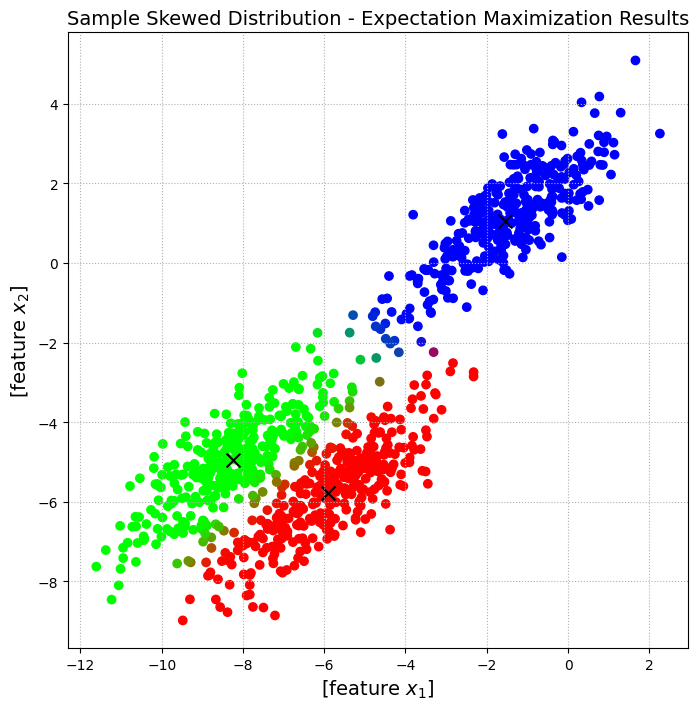

In [37]:
# init the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot x_1 vs. x_2 and corresponding cluster labels
scatter = ax.scatter(data_skewed[:,0], data_skewed[:,1], c=em_probabilities_skewed.astype(np.float64), cmap=plt.cm.Set1)

# plot cluster means
ax.scatter(em_means_skewed[:,0], em_means_skewed[:,1], marker='x', c='black', s=100)

# add axis legends
ax.set_xlabel("[feature $x_1$]", fontsize=14)
ax.set_ylabel("[feature $x_2$]", fontsize=14)

# add plot title
plt.title('Sample Skewed Distribution - Expectation Maximization Results', fontsize=14);

It can be observed that the EM-Clustering algorithm conducts a **"soft"** or **"fuzzy"** cluster assignment especially for observations that reside at the edges of the distinct clusters.

### 3.4 Bayesian Information Criterion (BIC) to find Optimum $k$

In chapter 3.3, we hypothesized that the correct number of clusters in our *skewed data* was $k = 3$. What if we were wrong? How can we be sure that $3$ is the correct value? What if we had no particular guess? One way to increase the likelihood that a given observation belongs to its closest cluster center is by increasing the number of clusters as the distances will be shorter. However, this can lead to **overfitting** (image an extreme scenario in which there are as many clusters as there are observations).

One way of mathematically determining the correct value $k$ should take is by using the **'Bayesian Information Criteria (BIC)'** technique.
Please note again, that for each algorithm available in the `sklearn` library, a designated and detailed documentation is provided. It often also includes a couple of practical examples and use cases. The documentation of the **BIC** algorithm can be obtained from the following url:

https://scikit-learn.org/stable/modules/mixture.html

**BIC** is a probabilistic statistical measure, which tries to express the model's performance on the training set. It is thus used for model selection and resembles other techniques like the *Akaike Information Criterion (AIC)*. It is useful in that it only requires the training set to find the optimal number of clusters *$k$*. Essentially, it expresses model performance based on different *$k$* values based on the model's performance and complexity.

It makes sure that on the one hand, model performance is optimized (we want to decrease fitting error) and that on the other hand, complexity is minimized (the simpler the model, the better). **BIC** consists of the following formula (there are some variants - this one is taken from The Elements of Statistical Learning, see https://link.springer.com/book/10.1007%2F978-0-387-84858-7):

$$BIC = -2 LL + k*ln(n)$$

where:
>- LL is the log-likelihood of the model (measures goodness of fit). It can be expressed as $LL = ln*P(x_{1}, .., x_{n}|k)$
>- *$k$* is the number of clusters (parameters)
>- *$n$* is the number of training samples

The **BIC** score is minimized so that the model with the lowest **BIC** is chosen.

As mentionned before, **BIC** deals with the performance/complexity trade-off. The first part of the equation ($-2LL$) looks at the fitting error and tries to minimize it, while the second part ($k*ln(n)$) deals with the model's complexity. A model with low error but a really high number of clusters is useless, as will be apparent in the visualization below.

Let's illustrate this using Python! We will write code based on https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py.

First, we compute the **BIC** scores for different *$k$* values, let's say in range(1, 10):

In [39]:
# Since we will want to replace this lowest BIC score variable with the
# lowest computed, we can first let it be infinity
lowest_bic = np.inf

# Create an empty list where we will append BIC scores for the different k values
bic = []

# Define range of k values
k_range = range(1, 10)

# Loop over them
for k_value in k_range:

    # We define the EM model
    gmm = GaussianMixture(n_components=k_value, max_iter=max_iterations, random_state=random_seed)

    # And fit it to the data for each k
    gmm.fit(data_skewed)

    # Append the BIC score the the list (use .bic method from sklearn)
    bic.append(gmm.bic(data_skewed))

    # If this particular score is the lowest yet, replace the lowest_bic value with it
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm

# Transform BIC list into an array
bic = np.array(bic)

# Designate the best of our classifiers
clf = best_gmm

Let's now verify the results by printing the best classifier's parameters, the **BIC** score for each *$k$* and the lowest **BIC** score.

In [40]:
print('Best classifier parameters:', clf)
print('\nBIC score for each value of k:', bic)
print('\nLowest BIC score:', lowest_bic)

Best classifier parameters: GaussianMixture(max_iter=50, n_components=3, random_state=42)

BIC score for each value of k: [8858.14620683 7942.30710316 7763.1382077  7807.89811435 7833.93388361
 7867.6156047  7904.015837   7950.62254778 7985.77005936]

Lowest BIC score: 7763.138207703456


We can now plot each *$k$*'s individual **BIC** score.

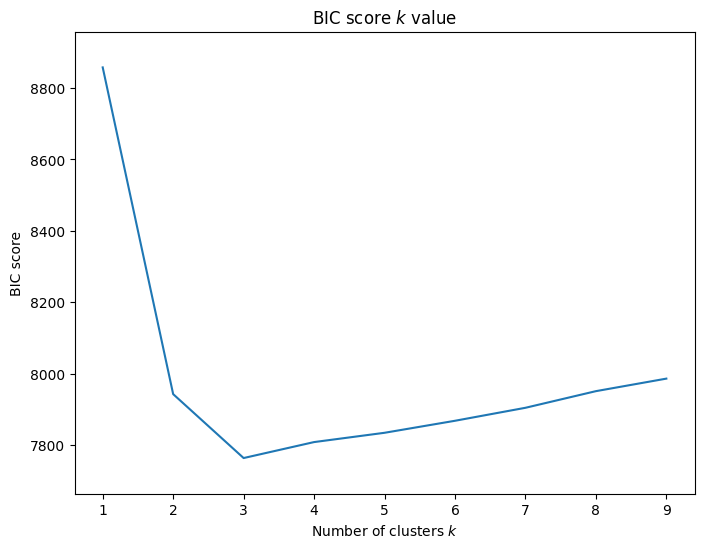

In [41]:
# Define figure and size
plt.figure(figsize=(8, 6))

# Ticks
plt.xticks(k_range)

# Define plot limit
plt.ylim([bic.min() - 100, bic.max() + 100])

# Title
plt.title('BIC score $k$ value')

# Plot the BIC scores (line)
plt.plot(k_range, bic)

# Lables
plt.ylabel('BIC score')
plt.xlabel('Number of clusters $k$')

plt.show()

Finally, let's see how chosing different *$k$* values would have affected the clusters by visualizing them!

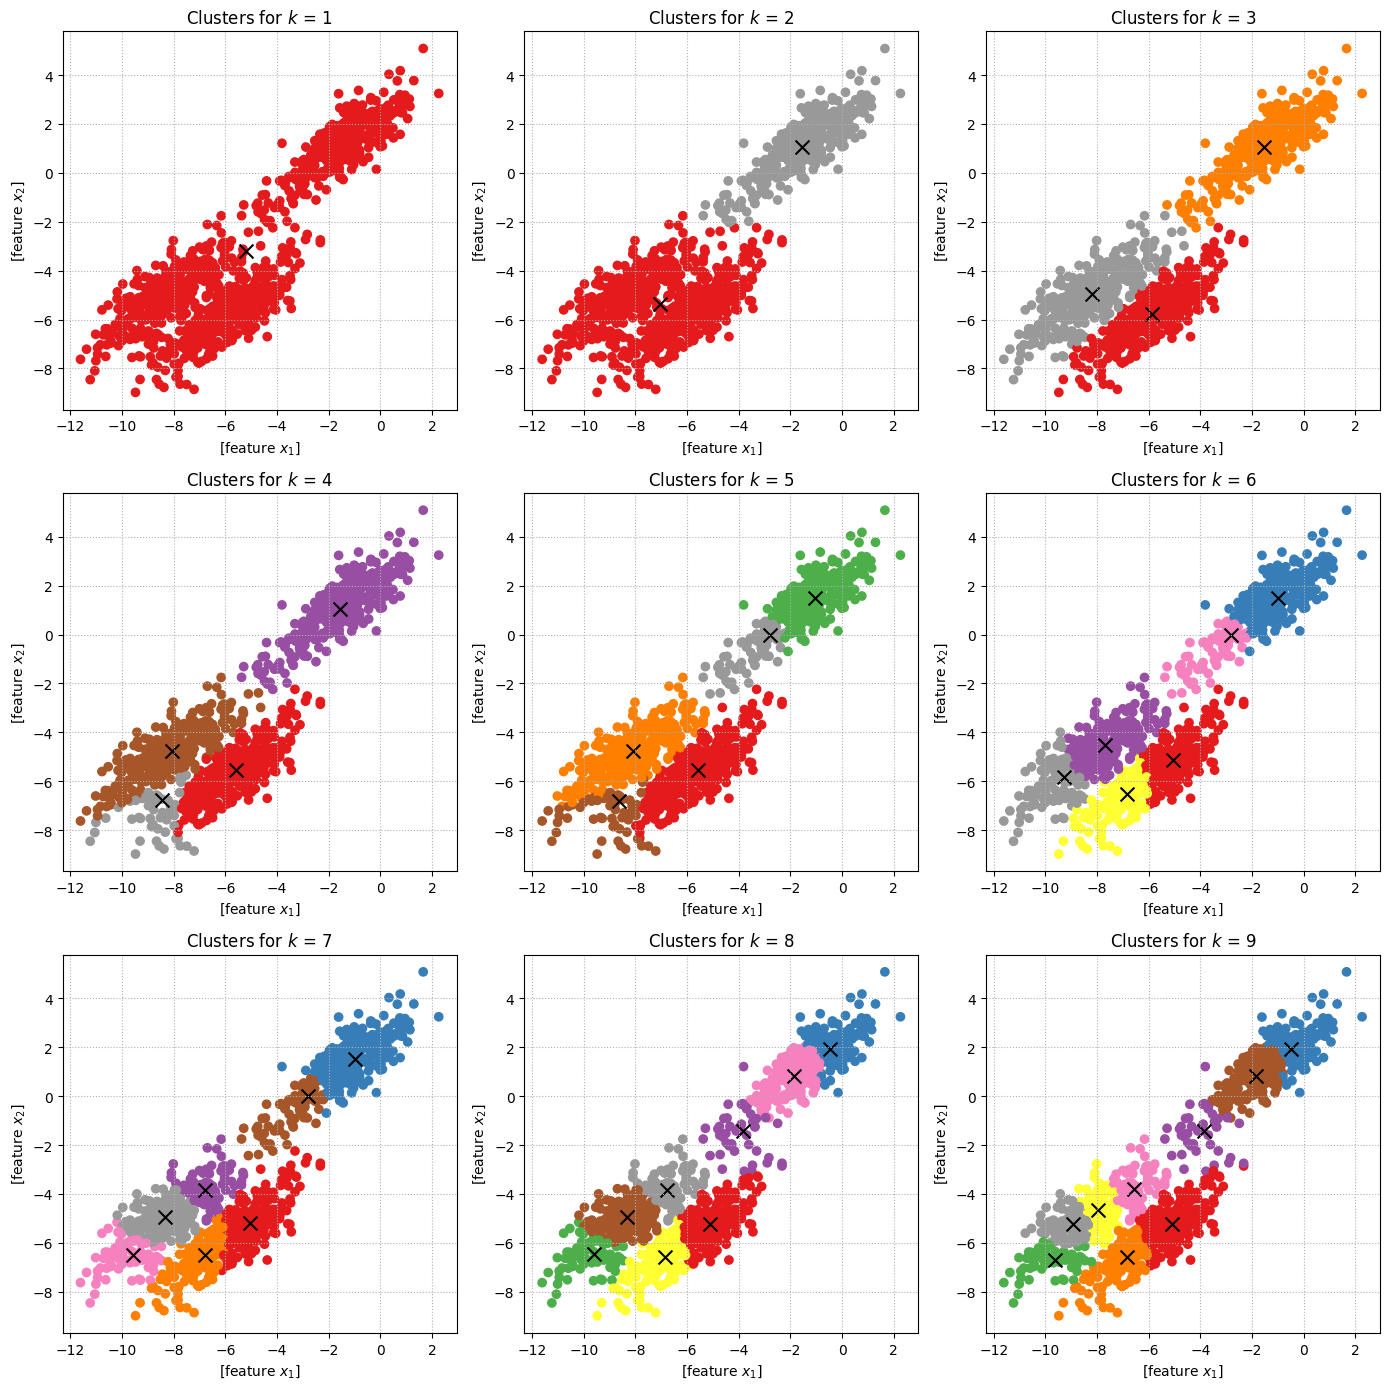

In [42]:
# Define figure and size
fig = plt.figure(1, (14, 14))

# Loop over k values
for k_value in k_range:

    # Fit EM with our skewed data
    gmm = GaussianMixture(n_components=k_value, max_iter=max_iterations, random_state=random_seed)
    gmm.fit(data_skewed)

    # Compute cluster membership and cluser means
    gmm_labels_skewed = gmm.predict(data_skewed)
    gmm_means_skewed = gmm.means_

    # Define subplot
    ax = plt.subplot(3, 3, k_value)

    # add grid
    ax.grid(linestyle='dotted')

    # plot x_1 vs. x_2 and corresponding cluster labels
    ax.scatter(data_skewed[:,0], data_skewed[:,1], c=gmm_labels_skewed.astype(np.float64), cmap=plt.cm.Set1)

    # plot cluster means
    ax.scatter(gmm_means_skewed[:,0], gmm_means_skewed[:,1], marker='x', c='black', s=100)

    # add axis legends
    ax.set_xlabel("[feature $x_1$]", fontsize=10)
    ax.set_ylabel("[feature $x_2$]", fontsize=10)

    # add plot title
    ax.set_title(f'Clusters for $k$ = {k_value}', fontsize=12)

    # make padding look nice
    plt.tight_layout();